In [2]:
# Cell 0: IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Carregar imagem de teste
imagem = cv2.imread("../../dataset/Cabbage/r0_3_100.jpg")

# Converter para escala de cinza
cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

In [7]:
# Cell 2: HISTOGRAM OF ORIENTED GRADIENTS (HOG)
def calcular_gradientes(imagem):
    """
    Calcula os gradientes da imagem usando filtros Sobel.
    
    Args:
        imagem: Imagem em escala de cinza
        
    Returns:
        tuple: (magnitude, angulo) dos gradientes
    """
    # Calcular gradientes usando Sobel
    grad_x = cv2.Sobel(imagem, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(imagem, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calcular magnitude e ângulo
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angulo = np.arctan2(grad_y, grad_x)
    
    # Converter ângulos para graus (0-180)
    angulo = np.degrees(angulo) % 180
    
    return magnitude, angulo

def calcular_hog(imagem, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualizar=True):
    """
    Calcula o Histogram of Oriented Gradients (HOG) de uma imagem.
    
    Args:
        imagem: Imagem em escala de cinza
        orientations: Número de orientações do gradiente (padrão: 9)
        pixels_per_cell: Tamanho da célula em pixels (padrão: (8, 8))
        cells_per_block: Número de células por bloco (padrão: (2, 2))
        visualizar: Se deve retornar imagem de visualização (padrão: True)
        
    Returns:
        tuple: (vetor_hog, imagem_hog) se visualizar=True, senão apenas vetor_hog
    """
    altura, largura = imagem.shape
    cell_h, cell_w = pixels_per_cell
    block_h, block_w = cells_per_block
    
    # Calcular gradientes
    magnitude, angulo = calcular_gradientes(imagem)
    
    # Calcular número de células
    n_cells_h = altura // cell_h
    n_cells_w = largura // cell_w
    
    # Inicializar histogramas das células
    cell_histograms = np.zeros((n_cells_h, n_cells_w, orientations))
    
    # Calcular histograma para cada célula
    bin_size = 180 / orientations
    
    for i in range(n_cells_h):
        for j in range(n_cells_w):
            # Definir região da célula
            y_start = i * cell_h
            y_end = (i + 1) * cell_h
            x_start = j * cell_w
            x_end = (j + 1) * cell_w
            
            # Extrair magnitude e ângulo da célula
            cell_mag = magnitude[y_start:y_end, x_start:x_end]
            cell_ang = angulo[y_start:y_end, x_start:x_end]
            
            # Calcular histograma da célula
            for y in range(cell_h):
                for x in range(cell_w):
                    mag_val = cell_mag[y, x]
                    ang_val = cell_ang[y, x]
                    
                    # Encontrar bins adjacentes
                    bin_idx = ang_val / bin_size
                    bin_low = int(bin_idx) % orientations
                    bin_high = (bin_low + 1) % orientations
                    
                    # Interpolação linear
                    weight = bin_idx - int(bin_idx)
                    cell_histograms[i, j, bin_low] += mag_val * (1 - weight)
                    cell_histograms[i, j, bin_high] += mag_val * weight
    
    # Normalização por blocos
    n_blocks_h = n_cells_h - block_h + 1
    n_blocks_w = n_cells_w - block_w + 1
    
    hog_features = []
    hog_image = np.zeros((altura, largura)) if visualizar else None
    
    for i in range(n_blocks_h):
        for j in range(n_blocks_w):
            # Extrair bloco de células
            block = cell_histograms[i:i+block_h, j:j+block_w, :]
            block_vector = block.flatten()
            
            # Normalização L2
            norm = np.sqrt(np.sum(block_vector**2) + 1e-6)
            block_vector = block_vector / norm
            
            hog_features.extend(block_vector)
            
            # Para visualização, adicionar à imagem HOG
            if visualizar:
                y_start = i * cell_h
                y_end = (i + block_h) * cell_h
                x_start = j * cell_w
                x_end = (j + block_w) * cell_w
                
                # Média das magnitudes normalizadas
                hog_image[y_start:y_end, x_start:x_end] += np.mean(block_vector)
    
    hog_features = np.array(hog_features)
    
    if visualizar:
        # Normalizar imagem HOG para visualização
        hog_image = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min() + 1e-6)
        return hog_features, hog_image
    else:
        return hog_features

# Calcular HOG
hog_features, hog_image = calcular_hog(cinza)

print(f"HOG calculado:")
print(f"  - Vetor HOG: {hog_features.shape}")
print(f"  - Número de características: {len(hog_features)}")
print(f"  - Primeiros 10 valores: {hog_features[:10]}")
print(f"  - Estatísticas do vetor:")
print(f"    * Mínimo: {hog_features.min():.4f}")
print(f"    * Máximo: {hog_features.max():.4f}")
print(f"    * Média: {hog_features.mean():.4f}")
print(f"    * Desvio padrão: {hog_features.std():.4f}")

HOG calculado:
  - Vetor HOG: (4356,)
  - Número de características: 4356
  - Primeiros 10 valores: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.20935236]
  - Estatísticas do vetor:
    * Mínimo: 0.0000
    * Máximo: 0.9626
    * Média: 0.1029
    * Desvio padrão: 0.1311


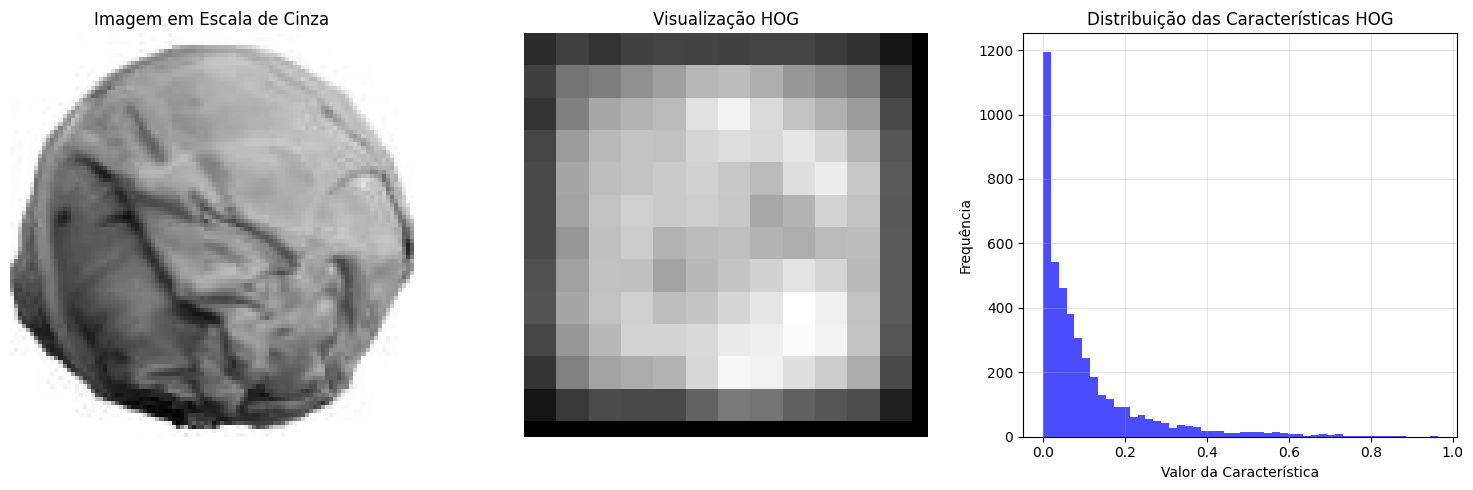

In [8]:
# Cell 3: VISUALIZAÇÃO DOS RESULTADOS HOG
plt.figure(figsize=(15, 5))

# Imagem em escala de cinza
plt.subplot(1, 3, 1)
plt.imshow(cinza, cmap='gray')
plt.title('Imagem em Escala de Cinza')
plt.axis('off')

# Visualização HOG
plt.subplot(1, 3, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('Visualização HOG')
plt.axis('off')

# Histograma das características HOG
plt.subplot(1, 3, 3)
plt.hist(hog_features, bins=50, alpha=0.7, color='blue')
plt.title('Distribuição das Características HOG')
plt.xlabel('Valor da Característica')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Cell 4: TESTE COM DIFERENTES PARÂMETROS
print("Testando diferentes configurações de HOG:")
print("=" * 50)

# Configurações para testar
configuracoes = [
    {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)},
    {'orientations': 12, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)},
    {'orientations': 9, 'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2)},
    {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}
]

for i, config in enumerate(configuracoes, 1):
    hog_vec = calcular_hog(cinza, visualizar=False, **config)
    
    print(f"\nConfiguração {i}:")
    print(f"  - Orientações: {config['orientations']}")
    print(f"  - Pixels por célula: {config['pixels_per_cell']}")
    print(f"  - Células por bloco: {config['cells_per_block']}")
    print(f"  - Dimensões do vetor: {hog_vec.shape[0]}")
    print(f"  - Média: {hog_vec.mean():.4f}")

Testando diferentes configurações de HOG:

Configuração 1:
  - Orientações: 9
  - Pixels por célula: (8, 8)
  - Células por bloco: (2, 2)
  - Dimensões do vetor: 4356
  - Média: 0.1029

Configuração 2:
  - Orientações: 12
  - Pixels por célula: (8, 8)
  - Células por bloco: (2, 2)
  - Dimensões do vetor: 5808
  - Média: 0.0853

Configuração 3:
  - Orientações: 9
  - Pixels por célula: (16, 16)
  - Células por bloco: (2, 2)
  - Dimensões do vetor: 900
  - Média: 0.1162

Configuração 4:
  - Orientações: 9
  - Pixels por célula: (8, 8)
  - Células por bloco: (3, 3)
  - Dimensões do vetor: 8100
  - Média: 0.0655


In [10]:
# Cell 5: FUNÇÃO OTIMIZADA PARA EXTRAÇÃO EM LOTE
def extrair_hog_lote(lista_imagens, **kwargs):
    """
    Extrai características HOG para uma lista de imagens.
    
    Args:
        lista_imagens: Lista de imagens em escala de cinza
        **kwargs: Parâmetros para a função calcular_hog
        
    Returns:
        np.ndarray: Matriz onde cada linha é o vetor HOG de uma imagem
    """
    vetores_hog = []
    
    for img in lista_imagens:
        hog_vec = calcular_hog(img, visualizar=False, **kwargs)
        vetores_hog.append(hog_vec)
    
    return np.array(vetores_hog)

# Exemplo de uso com múltiplas imagens
print("Função de extração em lote criada.")
print("Exemplo de uso:")
print("vetores = extrair_hog_lote([img1, img2, img3])")

Função de extração em lote criada.
Exemplo de uso:
vetores = extrair_hog_lote([img1, img2, img3])
